In [1]:
#!/usr/bin/python3

import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import LambdaLR
from utils import Logger
from utils import weights_init_normal
from datasets import ImageDataset, Flower_Dataset
from easydict import EasyDict
import os

from torch.utils import data
from torchvision import datasets, transforms

import gan_model

In [2]:
import torchvision.transforms as transforms

In [3]:
opt = EasyDict()

opt.epoch = 0
opt.n_epochs = 200
opt.batchSize = 20
opt.dataroot = 'datasets/'
opt.lr = 0.0002
opt.decay_epoch = 100
opt.size = 224
opt.input_nc = 3 #change from color to gray
opt.output_nc = 3
opt.n_cpu = 8
opt.lambda_identity = 0.5
opt.lambda_A = 10 
opt.lambda_B = 10 #back to color is given more importance

In [4]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else:  # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [5]:
###### Definition of variables ######
# Networks

netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

# netD_A = Discriminator(opt.input_nc)
# netD_B = Discriminator(opt.output_nc)

# netG_A2B = models.define_G(opt.input_nc, opt.output_nc, 64, 'unet_128', 'batch', 'False', 'normal', 0.02, [0])
# netG_B2A = models.define_G(opt.input_nc, opt.output_nc, 64, 'unet_128', 'batch', 'False', 'normal', 0.02, [0])


# netD_A = models.define_D(opt.input_nc, 64, 'basic', 3, 'batch', False, 'normal', 0.02, [0])
# netD_B = models.define_D(opt.output_nc, 64, 'basic', 3, 'batch', False, 'normal', 0.02, [0])


# netG_A2B = gan_model.ConvGen(opt.input_nc, opt.output_nc)
# netG_B2A = gan_model.ConvGen(opt.output_nc, opt.input_nc)
# netD_A = gan_model.ConvDis(opt.input_nc)
# netD_B = gan_model.ConvDis(opt.output_nc)
#gan_model

netG_A2B = netG_A2B.to(computing_device)
netG_B2A = netG_B2A.to(computing_device)
netD_A = netD_A.to(computing_device)
netD_B = netD_B.to(computing_device)

In [6]:
# from gan_model import *

# netG_A2B = ConvGen()
# netG_B2A = ConvGen()
# netD_A = ConvDis()
# netD_B = ConvDis()


# netG_A2B = netG_A2B.to(computing_device)
# netG_B2A = netG_B2A.to(computing_device)
# netD_A = netD_A.to(computing_device)
# netD_B = netD_B.to(computing_device)

In [7]:
import os  
fileCheck = os.path.isfile('output/netG_A2B.pth') 
print(fileCheck)

False


In [8]:
fileCheck = False

In [9]:
# if fileCheck:
#     print("previous weights are loaded")
#     netG_A2B.load_state_dict(torch.load('output/netG_A2B.pth'))
#     netG_B2A.load_state_dict(torch.load('output/netG_B2A.pth'))
#     netD_A.load_state_dict(torch.load('output/netD_A.pth'))
#     netD_B.load_state_dict(torch.load('output/netD_B.pth'))
    
# else:
#     print("weights are initialized")
#     netG_A2B.apply(weights_init_normal)
#     netG_B2A.apply(weights_init_normal)
#     netD_A.apply(weights_init_normal)
#     netD_B.apply(weights_init_normal)

In [10]:
# Lossess
criterion_GAN = torch.nn.MSELoss() #torch.nn.BCELoss() if need to use other loss
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(netD_A.parameters(), netD_B.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))

# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
# lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

In [11]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)

target_real = Variable(Tensor(opt.batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [12]:
transforms_ = [# transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                #transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]

In [13]:
# #split train and validation data
# import numpy as np
# from matplotlib import pyplot as plt

# images_gray = np.load(opt.dataroot+'A/gray_scale.npy')
# images_lab = np.load(opt.dataroot+'B/ab1.npy')
# np.save(opt.dataroot + 'Train/A/gray_scale.npy', images_gray[:300])
# np.save(opt.dataroot + 'Train/B/ab1.npy', images_lab[:300] )
# images_gray = np.load(opt.dataroot + 'Train/A/gray_scale.npy')
# images_lab = np.load(opt.dataroot + 'Train/B/ab1.npy')
# plt.figure()
# plt.imshow(images_gray[29],cmap='gray')
# plt.show()

# images_gray = np.load(opt.dataroot+'A/gray_scale.npy')
# images_lab = np.load(opt.dataroot+'B/ab1.npy')
# np.save(opt.dataroot + 'Test/A/gray_scale.npy', images_gray[1000:1030])
# np.save(opt.dataroot + 'Test/B/ab1.npy', images_lab[1000:1030])
# images_gray = np.load(opt.dataroot + 'Test/A/gray_scale.npy')
# images_lab = np.load(opt.dataroot + 'Test/B/ab1.npy')
# plt.figure()
# plt.imshow(images_gray[0],cmap='gray')
# plt.show()

In [14]:
# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input

# def get_rbg_from_lab(gray_imgs, ab_imgs, n = 10):
#     imgs = np.zeros((n, 224, 224, 3))
#     imgs[:, :, :, 0] = gray_imgs[0:n:]
#     imgs[:, :, :, 1:] = ab_imgs[0:n:]

#     imgs = imgs.astype("uint8")

#     imgs_ = []
#     for i in range(0, n):
#         imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

#     imgs_ = np.array(imgs_)

# #         print(imgs_.shape)

#     return imgs_

# def pipe_line_img(gray_scale_imgs, batch_size = 100, preprocess_f = preprocess_input):
#     imgs = np.zeros((batch_size, 224, 224, 3))
#     for i in range(0, 3):
#         imgs[:batch_size, :, :,i] = gray_scale_imgs[:batch_size]
#     return preprocess_f(imgs)


In [15]:
# from PIL import Image
# import numpy as np

# images_gray = np.load('datasets/Train/A/gray_scale.npy')
# files_A = pipe_line_img(images_gray, batch_size = images_gray.shape[0]).transpose(0, 3, 1, 2)
# img = files_A[0].transpose(1, 2, 0)
# # plt.imsave('output/test.png', [img, img])


# img_list = []

# image_list = [img, img, img]

# #np.concatenate((image_list), 1)

# img_list.append(np.concatenate((image_list), 1))
# img_list = np.array(img_list)
# img_list = np.squeeze(img_list, axis=0)
# # print(img_list.shape)
# plt.imsave('output/test.png', img_list)
# plt.axis("off")

# # total_width = 2*224
# # max_height = 224


# # new_im = Image.new('RGB', (total_width, max_height))
# # print(files_A[0].shape)
# # x_offset = 0
# # for im in range(2):
# #     img = files_A[im].transpose(1, 2, 0)
# #     print(img.shape)
# #     img = Image.fromarray(files_A[im], 'RGE')
# #     new_im.paste(img, (x_offset,0))
# #     img.save('output/'+str(im)+'.png')
# #     img.show()
# #     x_offset += 224

# # new_im.save('output/test.png')

In [16]:
trainDataloader = DataLoader(ImageDataset(opt.dataroot + 'Train/', transforms_ = transforms_), batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)
testDataloader = DataLoader(ImageDataset(opt.dataroot + 'Test/', transforms_ = transforms_), batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)

in here
rearranged (300, 3, 224, 224)
in here
rearranged (30, 3, 224, 224)


In [15]:
from datasets import Flower_Dataset as myDataset

data_train = myDataset( opt.dataroot,
        shuffle=True,
        small=False,
        mode='train',
        transform=transforms.Compose(transforms_),
        target_transform=None,
        types='')
trainDataloader = data.DataLoader(data_train,
                               batch_size= opt.batchSize,
                               shuffle=True,
                               num_workers=4)
data_val = myDataset(opt.dataroot,
                    shuffle=False,
                    small=False,
                    mode='test',
                    transform=transforms.Compose(transforms_),
                    target_transform=None,
                    types=''
                      )

testDataloader = data.DataLoader(data_val,
                                  batch_size=opt.batchSize,
                                  shuffle=False,
                                  num_workers=4)

Load 1020 images, used 0.049773s
Load 340 images, used 0.013726s


In [16]:
#%matplotlib inline

In [17]:
len(testDataloader)

17

In [32]:
# Loss plot
def validation(opt, val_logger, testDataloader, netG_A2B, netG_B2A, netD_A, netD_B, criterion_identity, criterion_GAN, criterion_cycle):

    netG_A2B.eval()
    netG_B2A.eval()
    netD_A.eval()
    netD_B.eval()
    
    lambda_idt = opt.lambda_identity
    lambda_A = opt.lambda_A
    lambda_B = opt.lambda_B

    ###################################
    
    with torch.no_grad():

        for i, batch in enumerate(testDataloader):
            # Set model input
    #         real_A = Variable(input_A.copy_(batch['A'])) #gray image
    #         real_B = Variable(input_B.copy_(batch['B'])) #colored image

#             real_B = Variable(input_A.copy_(batch['A'])) #gray image
#             real_A = Variable(input_B.copy_(batch['B'])) #colored image

            real_A = Variable(input_A.copy_(batch[0])) #gray image
            real_B = Variable(input_B.copy_(batch[1])) #colored image

            ###### Generators A2B and B2A ######

            # generate fakes 

            fake_B = netG_A2B(real_A)
            recovered_A = netG_B2A(fake_B)

            fake_A = netG_B2A(real_B)
            recovered_B = netG_A2B(fake_A)


            # Identity loss, condition         
            if lambda_idt > 0:
                # should be identity if real_B is fed.
                loss_identity_B = criterion_identity(netG_A2B(real_B), real_B) * lambda_B * lambda_idt
                # should be identity if real_A is fed.
                loss_identity_A = criterion_identity(netG_B2A(real_A), real_A) * lambda_A * lambda_idt
            else:
                loss_identity_B = 0
                loss_identity_A = 0

            # GAN loss
            loss_GAN_A2B = criterion_GAN(netD_B(fake_B), target_real)
            loss_GAN_B2A = criterion_GAN(netD_A(fake_A), target_real)


            # Cycle loss
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_A
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_B


            # combined loss
            loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            

            ###################################
            ###### Discriminator A ######

            # Real loss
            loss_D_real = criterion_GAN(netD_A(real_A), target_real)

            # Fake loss
            loss_D_fake = criterion_GAN(netD_A(fake_A_buffer.push_and_pop(fake_A).detach()), target_fake)

            # Total loss
            loss_D_A = (loss_D_real + loss_D_fake)*0.5
            

            ###################################

            ###### Discriminator B ######

            # Real loss
            loss_D_real = criterion_GAN(netD_B(real_B), target_real)

            # Fake loss
            loss_D_fake = criterion_GAN(netD_B(fake_B_buffer.push_and_pop(fake_B).detach()), target_fake)

            # Total loss
            loss_D_B = (loss_D_real + loss_D_fake)*0.5
            

            ###################################

            # Progress report (http://localhost:8097)
            val_logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                        'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
                        images={'real_A': real_A, 
                            'real_B': real_B, 
                            'fake_A': fake_A, 
                            'fake_B': fake_B}, mode='validation',
                        model={'netG_A2B': netG_A2B.state_dict(),'netG_B2A': netG_B2A.state_dict(),'netD_A': netD_A.state_dict(),'netD_B': netD_B.state_dict()}, lab=False)


In [33]:
# val_logger = Logger(opt.n_epochs, len(testDataloader))
# for epoch in range(opt.epoch, opt.n_epochs):
#     for i, batch in enumerate(testDataloader):
#         validation(opt, val_logger, testDataloader, netG_A2B, netG_B2A, netD_A, netD_B, criterion_identity, criterion_GAN, criterion_cycle)

In [34]:
# val_logger = Logger(opt.n_epochs, len(testDataloader))
# for i in range(4):
#       validation(opt, val_logger, testDataloader, netG_A2B, netG_B2A, netD_A, netD_B, criterion_identity, criterion_GAN, criterion_cycle)

In [35]:
# val_logger = Logger(opt.n_epochs, len(testDataloader))


# from skimage import color
# import numpy as np
# from matplotlib import pyplot as plt
# import cv2
# ###### Training ######
# for epoch in range(opt.epoch, opt.n_epochs):
#     for i, batch in enumerate(testDataloader):
#             real_A = Variable(input_A.copy_(batch[0])) #gray image
#             real_B = Variable(input_B.copy_(batch[1])) #colored image
            
#             img = real_B.cpu().numpy()[0]
            
#             plt.figure()
#             plt.imshow(img)#real_B.cpu().numpy()[0].transpose(1,2,0)[:,:,0])
#             plt.show()

/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 18 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 252 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current train total loss tensor(11.1525)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current validation total loss tensor(12.4385)
current is the best loss



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 19 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 29 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current train total loss tensor(10.9196)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 60 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 472 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current validation total loss tensor(11.3455)
current is the best loss



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 957 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current train total loss tensor(10.8411)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 1352 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current validation total loss tensor(9.2693)
current is the best loss



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 228 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current train total loss tensor(10.4391)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 343 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current validation total loss tensor(11.0102)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 299 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current train total loss tensor(10.5040)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 10 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 691 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current validation total loss tensor(11.3542)

current train total loss tensor(10.2503)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 209 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current validation total loss tensor(9.5602)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 132 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current train total loss tensor(9.9675)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 513 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current validation total loss tensor(10.4551)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 292 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current train total loss tensor(10.1700)



/datasets/home/72/372/mtanjim/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 341 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


current validation total loss tensor(9.1915)
current is the best loss



KeyboardInterrupt: 

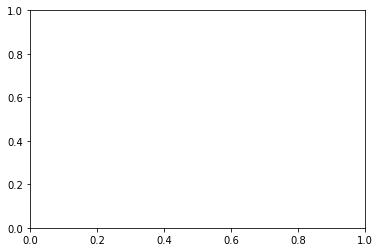

In [36]:
# Loss plot
train_logger = Logger(opt.n_epochs, len(trainDataloader))
val_logger = Logger(opt.n_epochs, len(testDataloader))

        
lambda_idt =  opt.lambda_identity
lambda_A = opt.lambda_A
lambda_B = opt.lambda_B
###################################

###### Training ######
for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(trainDataloader):
        # Set model input
#         real_A = Variable(input_A.copy_(batch['A'])) #gray image
#         real_B = Variable(input_B.copy_(batch['B'])) #colored image

#         real_B = Variable(input_A.copy_(batch['A'])) #gray image
#         real_A = Variable(input_B.copy_(batch['B'])) #colored image

        real_A = Variable(input_A.copy_(batch[0])) #gray image
        real_B = Variable(input_B.copy_(batch[1])) #colored image

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()
        
        
        # generate fakes 
        
        fake_B = netG_A2B(real_A)
        recovered_A = netG_B2A(fake_B)
        
        fake_A = netG_B2A(real_B)
        recovered_B = netG_A2B(fake_A)
        
       
        # Identity loss, condition         
        if lambda_idt > 0:
            # should be identity if real_B is fed.
            loss_identity_B = criterion_identity(netG_A2B(real_B), real_B) * lambda_B * lambda_idt
            # should be identity if real_A is fed.
            loss_identity_A = criterion_identity(netG_B2A(real_A), real_A) * lambda_A * lambda_idt
        else:
            loss_identity_B = 0
            loss_identity_A = 0
            
        # GAN loss
        loss_GAN_A2B = criterion_GAN(netD_B(fake_B), target_real)
        loss_GAN_B2A = criterion_GAN(netD_A(fake_A), target_real)
        
        
        # Cycle loss
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_A
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_B
        
        
        # combined loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################
        optimizer_D.zero_grad()
        ###### Discriminator A ######
        
        # Real loss
        loss_D_real = criterion_GAN(netD_A(real_A), target_real)

        # Fake loss
        loss_D_fake = criterion_GAN(netD_A(fake_A_buffer.push_and_pop(fake_A).detach()), target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        ###################################

        ###### Discriminator B ######

        # Real loss
        loss_D_real = criterion_GAN(netD_B(real_B), target_real)
        
        # Fake loss
        loss_D_fake = criterion_GAN(netD_B(fake_B_buffer.push_and_pop(fake_B).detach()), target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D.step()
        ###################################

        # Progress report (http://localhost:8097)
        train_logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 
                          'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                    'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
                    images={'real_A': real_A,
                            'real_B': real_B, 
                            'fake_A': fake_A, 
                            'fake_B': fake_B}, mode = 'train', lab=False)
        
    validation(opt, val_logger, testDataloader, netG_A2B, netG_B2A, netD_A, netD_B, criterion_identity, criterion_GAN, criterion_cycle)

    #Update learning rates
#     lr_scheduler_G.step()
#     lr_scheduler_D.step()

###################################

In [ ]:
# from utils import Logger

In [ ]:
%debug

In [ ]:
# for i in range(100):
#       # Progress report (http://localhost:8097)
#     logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
#                 'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
#                 images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})

In [ ]:
# for i in range(100):
#       # Progress report (http://localhost:8097)
#     logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
#                 'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
#                 images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})